In [1]:
!pip install datasets==3.3.2 --quiet
!pip install evaluate --quiet
!pip install accelerate -U --quiet

In [2]:
import requests
import torch
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
from tqdm import tqdm

device = "cpu"

/Users/shreyasavant/Desktop/comp6721/TissueMNIST/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model_name = "facebook/deit-base-distilled-patch16-224"                        # the model name
# Load image processor and explicitly set size to 224x224 to match the model
image_processor = ViTImageProcessor.from_pretrained(
    model_name,
    size={"height": 224, "width": 224}  # Explicitly set to 224x224 (model expects this size)
)
model = ViTForImageClassification.from_pretrained(model_name)     # loading the pre-trained model

# Verify the processor size
print(f"Image processor size: {image_processor.size}")
print(f"Expected model input size: 224x224")

You are using a model of type deit to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight', 'vit.embeddings.cls_token', 'vit.embeddings.patch_embeddings.projection.bias', 'vit.embeddings.patch_embeddings.projection.weight', 'vit.embeddings.position_embeddings', 'vit.encoder.layer.0.attention.attention.key.bias', 'vit.encoder.layer.0.attention.attention.key.weight', 'vit.encoder.layer.0.attention.attention.query.bias', 'vit.encoder.layer.0.attention.attention.query.weight', 'vit.encoder.layer.0.attention.attention.value.bias', 'vit.encoder.layer.0.attention.attention.value.weight', 'vit.encoder.layer.0.attention.output.dense.bias', 'vit.encoder.layer.0.attention.output.dense.weight', 'vit.encoder.layer.0.intermediate.dense.bias', 'vit

Image processor size: {'height': 224, 'width': 224}
Expected model input size: 224x224


**Load Dataset**

In [4]:
from datasets import load_dataset

ds = load_dataset("albertvillanova/medmnist-v2", "tissuemnist")    # download & load the dataset

Generating train split: 165466 examples [00:15, 10676.91 examples/s]
Generating validation split: 23640 examples [00:01, 12528.30 examples/s]
Generating test split: 47280 examples [00:03, 12247.26 examples/s]


In [ ]:
labels = ds["train"].features["label"]
print(f"Label feature: {labels}")
print(f"Number of classes: {labels.num_classes if hasattr(labels, 'num_classes') else len(labels.names) if hasattr(labels, 'names') else 'Unknown'}")
print(f"Label names: {labels.names if hasattr(labels, 'names') else 'N/A'}")

# Check label values in the dataset
print("\nChecking label values in dataset:")
sample_labels = [ds["train"][i]["label"] for i in range(min(100, len(ds["train"])))]
unique_labels = sorted(set(sample_labels))
print(f"Unique labels found (first 100 samples): {unique_labels}")
print(f"Min label: {min(sample_labels)}, Max label: {max(sample_labels)}")
if hasattr(labels, 'num_classes'):
    expected_max = labels.num_classes - 1
    if max(sample_labels) > expected_max:
        print(f"⚠ ERROR: Max label ({max(sample_labels)}) exceeds expected range [0, {expected_max}]")
    else:
        print(f"✓ Labels are in valid range [0, {expected_max}]")

ClassLabel(names=['Collecting Duct, Connecting Tubule', 'Distal Convoluted Tubule', 'Glomerular endothelial cells', 'Interstitial endothelial cells', 'Leukocytes', 'Podocytes', 'Proximal Tubule Segments', 'Thick Ascending Limb'], id=None)

**Data Preprocessing**

In [ ]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")

  # we also shouldn't forget about the labels
  # Ensure labels are integers and in valid range
  labels = examples["label"]
  
  # Convert to list if single value, ensure int type
  import numpy as np
  if isinstance(labels, (int, np.integer)):
    labels = [int(labels)]
  else:
    labels = [int(l) for l in labels]
  
  # Validate label range (will be checked against num_labels later)
  inputs["labels"] = labels

  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

# Verify transformed dataset labels
print("Verifying transformed dataset labels...")
sample_item = dataset["train"][0]
print(f"Sample label type: {type(sample_item['labels'])}")
print(f"Sample label value: {sample_item['labels']}")

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(dataset, split, index):
    data = dataset[split][index]
    if "image" in data:  # Original dataset
        image = data["image"]
        label = data["label"]

        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Class {label}", fontsize=8)
        plt.show()
    else:  # Transformed dataset
        image_tensor = data['pixel_values']
        label = data['labels']

        # Denormalize the image for display
        # ViTImageProcessor uses ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        # Convert tensor to numpy and denormalize
        image_array = image_tensor.numpy()  # Shape: (C, H, W)
        
        # Denormalize: pixel = (normalized_pixel * std) + mean
        # Transpose to (H, W, C) for easier processing
        image_array = image_array.transpose(1, 2, 0)  # Shape: (H, W, C)
        image_array = image_array * std + mean
        
        # Clip to valid range [0, 1] for display
        image_array = np.clip(image_array, 0, 1)
        
        plt.figure(figsize=(1, 1))
        plt.imshow(image_array)
        plt.title(f"Class {label}", fontsize=8)
        plt.axis('off')
        plt.show()

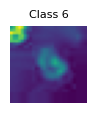

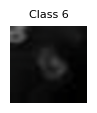

In [13]:
idx = 2
show_image(ds, "train", idx)
show_image(dataset, "train", idx)

In [14]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
0


In [ ]:
labels = ds["train"].features["label"].names
print(f"Label names: {labels}")
print(f"Number of classes: {len(labels)}")

def collate_fn(batch):
  # Extract labels and ensure they are integers
  label_list = []
  for x in batch:
    label = x["labels"]
    # Handle both tensor and int types
    if isinstance(label, torch.Tensor):
      label = label.item()
    label_list.append(int(label))
  
  # Validate labels are in range [0, num_classes-1]
  num_classes = len(labels)
  for label in label_list:
    if label < 0 or label >= num_classes:
      raise ValueError(f"Invalid label {label} found! Must be in range [0, {num_classes-1}]")
  
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor(label_list, dtype=torch.long),  # Ensure long dtype for classification
  }

# Test collate function
print("\nTesting collate function...")
test_batch = [dataset["train"][i] for i in range(2)]
try:
    test_output = collate_fn(test_batch)
    print(f"✓ Collate function works correctly")
    print(f"  Batch labels: {test_output['labels']}")
    print(f"  Label dtype: {test_output['labels'].dtype}")
except Exception as e:
    print(f"✗ Error in collate function: {e}")

In [16]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [ ]:
# Verify labels before model initialization
print(f"Labels: {labels}")
print(f"Number of labels: {len(labels)}")
print(f"Expected label range: [0, {len(labels)-1}]")

# Check actual label values in dataset
print("\nValidating label values in dataset...")
all_labels = []
for i in range(min(1000, len(dataset["train"]))):
    label = dataset["train"][i]["labels"]
    if isinstance(label, torch.Tensor):
        label = label.item()
    all_labels.append(int(label))

unique_labels = sorted(set(all_labels))
min_label, max_label = min(all_labels), max(all_labels)
print(f"Unique labels found: {unique_labels}")
print(f"Label range: [{min_label}, {max_label}]")
print(f"Expected range: [0, {len(labels)-1}]")

if max_label >= len(labels):
    print(f"⚠ ERROR: Max label ({max_label}) >= num_labels ({len(labels)})")
    print("This will cause CUDA assert error! Labels must be in range [0, num_labels-1]")
elif min_label < 0:
    print(f"⚠ ERROR: Min label ({min_label}) < 0")
    print("Labels must be non-negative!")
else:
    print("✓ Labels are in valid range")

# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

print(f"\n✓ Model initialized with {len(labels)} classes")
print(f"Model classifier output size: {model.classifier.out_features}")

You are using a model of type deit to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight', 'vit.embeddings.cls_token', 'vit.embeddings.patch_embeddings.projection.bias', 'vit.embeddings.patch_embeddings.projection.weight', 'vit.embeddings.position_embeddings', 'vit.encoder.layer.0.attention.attention.key.bias', 'vit.encoder.layer.0.attention.attention.key.weight', 'vit.encoder.layer.0.attention.attention.query.bias', 'vit.encoder.layer.0.attention.attention.query.weight', 'vit.encoder.layer.0.attention.attention.value.bias', 'vit.encoder.layer.0.attention.attention.value.weight', 'vit.encoder.layer.0.attention.output.dense.bias', 'vit.encoder.layer.0.attention.output.dense.weight', 'vit.encoder.layer.0.intermediate.dense.bias', 'vit

In [18]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.57.1', '1.12.0')

In [20]:
# defining the training arguments
training_args = TrainingArguments(
  output_dir="./vit-base-food", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=32, # batch size per device during training
  eval_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=10,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=374,                # number of update steps before saving checkpoint
  eval_steps=374,                # number of update steps before evaluating
  logging_steps=374,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)


In [22]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["validation"], # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

/var/folders/lm/kpd8qc0901b3tgvjj3l3r8lm0000gt/T/ipykernel_46151/1791216567.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/Users/shreyasavant/Desktop/comp6721/TissueMNIST/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


In [17]:
trainer.evaluate(dataset["test"])

{'eval_loss': 0.10169176012277603,
 'eval_accuracy': 0.9789535223618825,
 'eval_f1': 0.9789109306819832,
 'eval_runtime': 54.6044,
 'eval_samples_per_second': 62.651,
 'eval_steps_per_second': 7.838,
 'epoch': 10.0}

**Evaluation with Confusion Matrix**

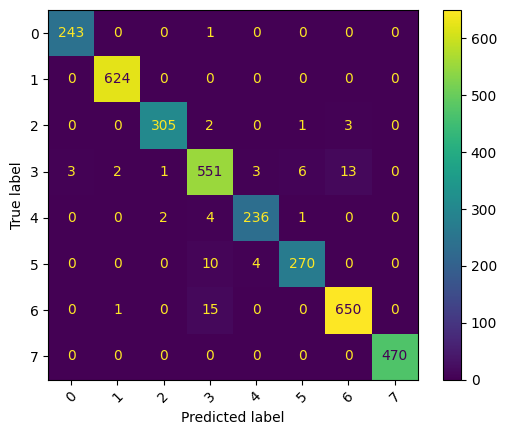

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(dataset["test"])
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = dataset["train"].features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

**Generate Precision, Recall, F1 Score, Support**

In [19]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

(array([0.98780488, 0.99521531, 0.99025974, 0.94511149, 0.97119342,
        0.97122302, 0.97597598, 1.        ]),
 array([0.99590164, 1.        , 0.9807074 , 0.95164076, 0.97119342,
        0.95070423, 0.97597598, 1.        ]),
 array([0.99183673, 0.99760192, 0.98546042, 0.94836489, 0.97119342,
        0.96085409, 0.97597598, 1.        ]),
 array([244, 624, 311, 579, 243, 284, 666, 470]))

**Generate Training & Loss Curves**

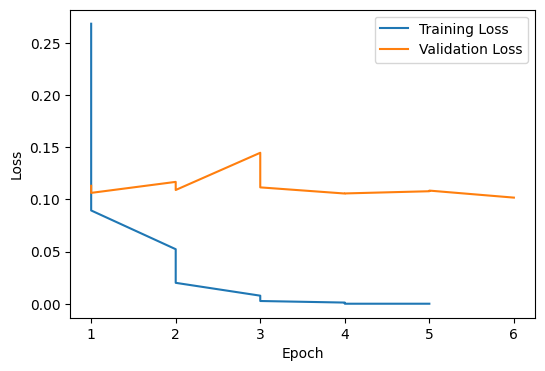

In [20]:
import matplotlib.pyplot as plt

data = trainer.state.log_history
# Extracting data for plotting
epochs = [entry['epoch'] for entry in data]  # Extract epoch values
train_losses = [entry['loss'] for entry in data if 'loss' in entry]  # Extract training losses
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]  # Extract evaluation losses

# Plotting training and evaluation metrics
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Evaluation Metrics Across Epochs')
plt.legend()
# plt.grid(True)
plt.show()

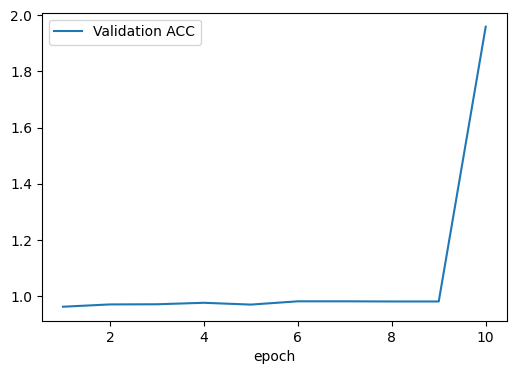

In [21]:
import pandas as pd

loghistory = pd.DataFrame(trainer.state.log_history)
loghistory = loghistory.fillna(0)
loghistory = loghistory.groupby(['epoch']).sum()
fig, ax = plt.subplots(figsize=(6, 4))  # Set the size here (width, height)
loghistory[["eval_accuracy"]].plot(subplots=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Validation ACC'], loc='best')
plt.show()  # Display the plot

**Plot ROC Curves**

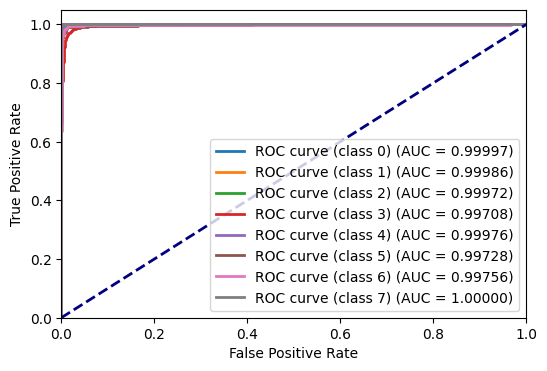

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predictions and true labels for multi-class classification
# predictions shape: (num_samples, num_classes), where each row contains class probabilities
# true_labels shape: (num_samples,), where each value represents the true class label
true_labels = outputs.label_ids
predictions = outputs.predictions

# Compute ROC curve for each class
num_classes = predictions.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.5f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()